# =========== ANÁLISIS DE MÉTRICAS ===========

In [19]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt

files_path = "data/"

invalid = -1

In [20]:
def read_json():
    # Obtener la lista de archivos en el directorio
    json_files = [file for file in os.listdir(files_path) if file.endswith('.json')]
    
    # Diccionario para almacenar los datos por usuario
    data_per_user = {}
    
    # Leer cada archivo JSON y almacenar los datos
    for file in json_files:
        with open(os.path.join(files_path, file), 'r') as f:
            data = json.load(f)
            for event in data:
                user_id = event["userID"]
                if user_id not in data_per_user:
                    data_per_user[user_id] = []
                data_per_user[user_id].append(event)
    
    # Ordenar eventos por timestamp para cada usuario
    for user_id, events in data_per_user.items():
        data_per_user[user_id] = sorted(events, key=lambda x: x["timeStamp"])
    
    return data_per_user

### Número de fallos hasta llegar a la P4 por primera vez. Se considera fallo cuando el pez pasa de la plataforma ‘i’ a cualquier plataforma menor que ‘i’.

In [21]:
# Devuelve una lista con los fallos antes de pasar P4, cada valor de la lista es una partida
def FirstMetric(events):

    failures_before_P4 = 0
    failed_platforms = []
    p4Passed = False

    game_start = None
    jump_start = None
    game_end = None
    jump_end = None


    for event in events:
        
        event_type = event.get('eventType')
        
        if event_type == 'GAME_START' and game_start is None:
            game_start = event

        elif event_type == 'JUMP_START':

            if game_end is not None:
                game_start = None
                game_end = None
            elif jump_start is None:
                jump_start = event

        elif event_type == 'GAME_END' or  event_type == 'SESSION_END':

            game_end = event
            game_start = None

            failures_before_P4 = 0
            p4Passed = False

        elif event_type == 'JUMP_END':

            if jump_start is not None:
                jump_end = event
                platformIdJumpStart = int(jump_start.get('platformId'))
                platformIdJumpEnd = int(jump_end.get('platformId'))
                
                # Si hay fallo 
                if platformIdJumpEnd < platformIdJumpStart and p4Passed is False:
                    failed_platforms.append(platformIdJumpStart)
                    failures_before_P4 += 1
                
                # Reseteamos los eventos de saltar
                jump_start = None
                jump_end = None

                # Si ya se ha llegado a la P4 ya no se cuenta más veces
                if platformIdJumpEnd >= 4:
                    p4Passed = True
                    game_start = None
                    game_end = None
                    break

    
    
    if(p4Passed == False) :
        failures_before_P4=invalid

    return failures_before_P4, failed_platforms

### Tasa de recolocación: plataformas en las que el usuario utiliza “WASD” para moverte al menos una vez entre las plataformas pisadas superiores a P1.

In [22]:
# Devuelve una lista de arrays que contiene las veces que te has movido en cada plataforma, cada array de la lista es una partida
def SecondMetric(events):
    
    movesInEachPlatform = []
    games = []

    game_start = None
    game_end = None

    for event in events:
        event_type = event.get('eventType')
        
        if event_type == 'GAME_START' and game_start is None:
            game_start = event

        elif event_type == 'PLAYER_MOVE':

            if game_end is not None:
                game_start = None
                game_end = None
            else:
                platformId = int(event.get('platformId'))

                if platformId != 1:
                    movesInEachPlatform[-1] += 1

        
        elif event_type == 'JUMP_END':
            platformId = int(event.get('platformId'))

            if platformId != 1:
                movesInEachPlatform.append(0)


        elif event_type == 'GAME_END':

            game_end = event
            game_start = None

            # Si acaba una partida y ha habido al menos un movimiento lo guardamos 
            if any(movesInEachPlatform):
                moves = np.count_nonzero(movesInEachPlatform)
                games.append(moves/len(movesInEachPlatform))
                movesInEachPlatform = []
    
    # Ahora realizar la media de games
    games

    return games

### Número de fallos de las plataformas P4, P15 y P22 antes de superarlas por primera vez. Hemos elegido estas plataformas porque en ellas es necesario el uso de los rebotes.

In [23]:
# Devuelve una lista de eventos donde cada elemento es otra lista con 3 elementos, uno por cada plataforma a medir 
def ThirdMetric(events):

    rebound_platforms = [4,15,22]
    failures_in_rebound_platforms = np.zeros(3)

    index = 0

    game_start = None
    jump_start = None
    game_end = None
    jump_end = None

    for event in events:
        event_type = event.get('eventType')

        if event_type == 'GAME_START' and game_start is None:
            game_start = event

        elif event_type == 'JUMP_START':

            if game_end is not None:
                game_start = None
                game_end = None
            elif jump_start is None:
                jump_start = event

        elif event_type == 'GAME_END' or event_type == 'SESSION_END':

            game_end = event
            game_start = None

        elif event_type == 'JUMP_END':

            if jump_start is not None:
                jump_end = event
                platformIdJumpStart = int(jump_start.get('platformId'))
                platformIdJumpEnd = int(jump_end.get('platformId'))

                # Reseteamos los eventos de saltar
                jump_start = None
                jump_end = None

                for reboundPlatform in rebound_platforms:
                    if platformIdJumpStart == reboundPlatform:

                        if platformIdJumpEnd < platformIdJumpStart:
                            failures_in_rebound_platforms[index] += 1
                            
                        elif platformIdJumpEnd > platformIdJumpStart:
                            del rebound_platforms[0]
                            index += 1

                    elif platformIdJumpStart < reboundPlatform and platformIdJumpEnd > reboundPlatform:
                            del rebound_platforms[0]
                            index += 1

                if not rebound_platforms:
                    break

    if(len(rebound_platforms)!=0):
        # Iterar sobre el segundo array en orden descendente
        for i in range(len(rebound_platforms) - 1, -1, -1):
            failures_in_rebound_platforms[-(i+1)] = invalid
            
            
    return failures_in_rebound_platforms

1º MÉTRICA:  MEDIA DE FALLOS ANTES DE PASAR P4 POR PRIMERA VEZ


0.25


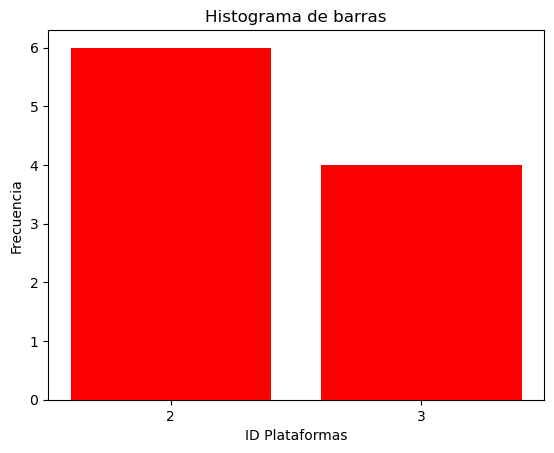



Descripcion del valor obtenido:
El siguiente valor indica cuantos fallos a tenido de media en la primera partida registrada de cada uno de los jugadores antes de alcanzar la plataforma 4.
 La media de todos esos valores es la metrica que se muestra a continuación.




2º MÉTRICA: MEIDIA DE TASA DE RECOLOCACIÓN POR PARTIDA


0.22783113860608833


Descripción del valor obtenido:
Media de la tasa de recolocación.  
 Se define tasa de recolocación como plataformas en las que el usuario utiliza “WASD” para moverte al menos una vez entre las plataformas pisadas superiores a P1. La tasa de recolocación se mide por partida.
Es decir, se divide el número de veces que el jugador ha movido a su personaje en cualquier plataforma, entre el número de plataformas que ha recorrido en total en esta partida 
 Por lo tanto, se obtiene un numero decimal entre 0 y 1 que muestra la cantidad de veces que este jugador ha usado el movimiento del personaje en esta partida concreta. 
 La media de los valores d

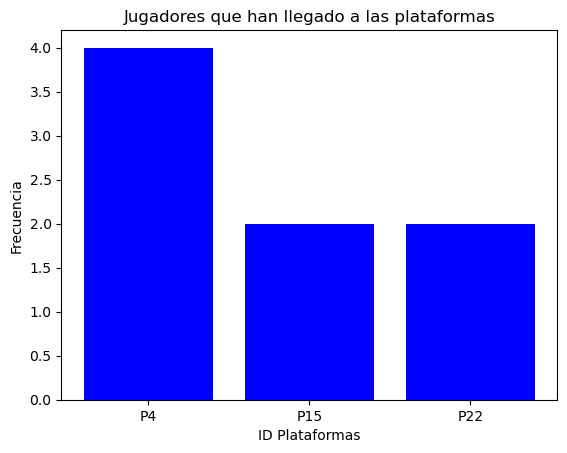



Descripción del valor obtenido:
Media de fallos de las plataformas P4, P15 y P22 antes de superarlas por primera vez.
Es decir, para cada una de las plataformas P4, P15 y P22, se calculan los fallos que ha tenido un jugador antes de superarlas por primera vez, con lo que se saca una media de fallos por jugador
 Cada jugador, generara entonces un valor por cada una de las tres plataformas.
 La media de los valores de todos los jugadores)


In [24]:
data_per_user = read_json()

valid_users = 0
total = 0
total_failed_platforms = []

print("=========================================================================")
print("1º MÉTRICA:  MEDIA DE FALLOS ANTES DE PASAR P4 POR PRIMERA VEZ")
print("=========================================================================")
print("\n")

for user_id, events in data_per_user.items():
    failures_before_P4, failed_platforms = FirstMetric(events)
    if(failures_before_P4>-1):
        valid_users+=1
        total += failures_before_P4
        total_failed_platforms.append(failed_platforms)

mean_failures = total / (valid_users)
print(mean_failures)

all_failures = [platform for platforms in total_failed_platforms for platform in platforms]

# Conteo de frecuencias de cada valor
counts = {}
for value in all_failures:
    counts[value] = counts.get(value, 0) + 1

values = list(counts.keys())
frequencies = list(counts.values())

plt.bar(values, frequencies, color='red')
plt.xticks(range(min(values), max(values) + 1))
plt.xlabel('ID Plataformas')
plt.ylabel('Frecuencia')
plt.title('Histograma de barras')
plt.show()

print("\n")
print("Descripcion del valor obtenido:")
print("===============================")
print("El siguiente valor indica cuantos fallos a tenido de media en la primera partida registrada de cada uno de los jugadores antes de alcanzar la plataforma 4."
        + "\n La media de todos esos valores es la metrica que se muestra a continuación.")


print("\n")
print("\n")
print("=========================================================================")
print("2º MÉTRICA: MEIDIA DE TASA DE RECOLOCACIÓN POR PARTIDA")
print("=========================================================================")
print("\n")

# Media de la tasa de recolocacion por partida
usersMetrics = []

for user_id, events in data_per_user.items():
    metric = SecondMetric(events)

    # Hacer la media de las metricas de este usuario concreto
    userMean = sum(metric) / len(metric)

    # Guardar la media de este usuario en el array
    usersMetrics.append(userMean)

# Calcular la media total entre todos los usuarios
meanValue =  sum(usersMetrics) / len(usersMetrics)

print(meanValue)
 

print("\n")
print("Descripción del valor obtenido:")
print("===============================")
print("Media de la tasa de recolocación. "
+ " \n Se define tasa de recolocación como plataformas en las que el usuario utiliza “WASD” para moverte al menos una vez entre las plataformas pisadas superiores a P1. La tasa de recolocación se mide por partida.")
print("Es decir, se divide el número de veces que el jugador ha movido a su personaje en cualquier plataforma, entre el número de plataformas que ha recorrido en total en esta partida"
+ " \n Por lo tanto, se obtiene un numero decimal entre 0 y 1 que muestra la cantidad de veces que este jugador ha usado el movimiento del personaje en esta partida concreta."
+ " \n La media de los valores de todas las partidas registradas es la métrica que se muestra a continuación.")
    
print("\n")
print("\n")
print("=========================================================================")
print("3º METRICA: MEDIA DE FALLOS ANTES DE PASAR POR PRIMERA VEZ P4, P15 y P22")
print("=========================================================================")
print("\n")


rebound_platforms = np.array(["P4", "P15", "P22"])

valid_users_per_platform = np.zeros(len(rebound_platforms))
total_failures_in_rebound_platforms = np.zeros(len(rebound_platforms))
array_of_lists = [[] for _ in range(len(rebound_platforms))]


for user_id, events in data_per_user.items():
    failures_in_rebound_platforms = ThirdMetric(events)

    for index, failures_in_platform in enumerate(failures_in_rebound_platforms):
        if failures_in_platform > -1:
            total_failures_in_rebound_platforms[index] += failures_in_platform
            valid_users_per_platform[index] += 1
            array_of_lists[index].append(failures_in_platform)
        

means = np.zeros(len(rebound_platforms))


for index, failures_in_platform in enumerate(total_failures_in_rebound_platforms):

    mean = failures_in_platform/valid_users_per_platform[index]
    means[index] = mean

    if(failures_in_platform > -1):
        print("MEDIA DE FALLOS DE " + rebound_platforms[index] + ": " + str(mean))

print("\n")

for index, list_ in enumerate(array_of_lists):
    summation = 0
    for elemnt in list_:
        summation += np.square((elemnt-means[index]))

    div = summation/valid_users_per_platform[index]
    print("DESVIACION TIPICA DE FALLOS EN " + rebound_platforms[index] + ": " + str(np.sqrt(div)))


plt.bar(rebound_platforms, valid_users_per_platform, color='blue')
plt.xlabel('ID Plataformas')
plt.ylabel('Frecuencia')
plt.title('Jugadores que han llegado a las plataformas')
plt.show()

print("\n")
print("Descripción del valor obtenido:")
print("===============================")
print("Media de fallos de las plataformas P4, P15 y P22 antes de superarlas por primera vez.")
print("Es decir, para cada una de las plataformas P4, P15 y P22, se calculan los fallos que ha tenido un jugador antes de superarlas por primera vez, con lo que se saca una media de fallos por jugador"
    + "\n Cada jugador, generara entonces un valor por cada una de las tres plataformas."
    + "\n La media de los valores de todos los jugadores)")

